# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [1]:
#immport basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#imports headline cleaning
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dominik Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
#import basic api requirements
from polygon import RESTClient
import datetime
import time
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [6]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

No Data Cleaning

In [ ]:
#first Look
print(data.columns)
data.sample(7)

In [ ]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

In [ ]:
data.count()

In [ ]:
stock = data.groupby("stock")
stock.sample()

In [ ]:
stock.describe()

In [ ]:
data['date']

### Data Visualization

In [ ]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

In [ ]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

In [ ]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [ ]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [ ]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

In [ ]:
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

In [ ]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [ ]:
import statistics

print(statistics.mean(year.size()))

In [ ]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

#### Wordclouds before Data Cleaning

WorldCloud over all Stocks, Top 50 Words:


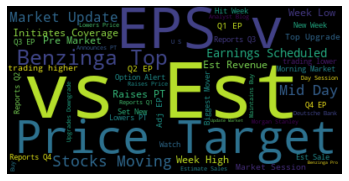

In [5]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

In [ ]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

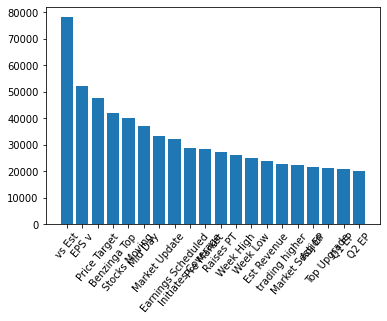

In [6]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling before Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

### Data Quality

In [ ]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

In [ ]:
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

In [ ]:
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

## Data Preparation

### Clean

In [7]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years
data = data.drop(data[data.date < '2019-08-21'].index)


In [8]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


## Headline Cleaning & Pre-Processing
### Hier wird nochmal speziell jede einzelene Headline mit WordNet den typischen pre-processing Schritten unterzogen

In [9]:
#POS Tagging
#Beim Part Of Speech Tagging wird geprüft, ob es sich um ein Nomen, Adjevtiv etc. handelt. Das unterstützt das Lammatisieren

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result


In [10]:
#Tokenization und POS-Tagging durchführen
data['headlines_cleaned'] = data['headline'].apply(tokenize_post)


In [11]:
data['headlines_cleaned'].head()

0    [[Stocks, n], [That, ], [Hit, v], [52-Week, a]...
1    [[Stocks, n], [That, ], [Hit, v], [52-Week, a]...
2    [[71, ], [Biggest, a], [Movers, n], [From, ], ...
3    [[46, ], [Stocks, n], [Moving, v], [In, ], [Fr...
4    [[B, n], [of, ], [A, n], [Securities, n], [Mai...
Name: headlines_cleaned, dtype: object

CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent’s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO, to go ‘to’ the store.
UH interjection, errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when

In [ ]:
# data.to_csv('../data/data_post_tokenz.csv')

In [12]:
#funktionen für Lowercase und Stopword-removal

#alle pos-tagged wörter der headlines werden jetzt nochmal kleingeschrieben
def lowercase(headline_post_tok):
    hl_post_tok_lower = []
    for word_pos in headline_post_tok:
        hl_post_tok_lower.append(tuple([word_pos[0].lower(), word_pos[1]]))
    return hl_post_tok_lower
    
#Stopwords aus dem NLTK Modul nehmen und entfernen
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    #hier könnte man noch ein paar eigene Stopwords hinzufügen
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence
    


    



In [13]:
#Headlines lowercase machen und danach anzeigen
data['headlines_cleaned'] = data['headlines_cleaned'].apply(lowercase)
data.head()

,id,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,"[(stocks, n), (that, ), (hit, v), (52-week, a)..."
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,"[(stocks, n), (that, ), (hit, v), (52-week, a)..."
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,"[(71, ), (biggest, a), (movers, n), (from, ), ..."
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,"[(46, ), (stocks, n), (moving, v), (in, ), (fr..."
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,"[(b, n), (of, ), (a, n), (securities, n), (mai..."


In [14]:
#jetzt das stopword removal durchführen
data['headlines_cleaned'] = data['headlines_cleaned'].apply(remove_stopwords)
data.head()

,id,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,"[(stocks, n), (hit, v), (52-week, a), (highs, ..."
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,"[(stocks, n), (hit, v), (52-week, a), (highs, ..."
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,"[(71, ), (biggest, a), (movers, n), (friday, n)]"
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,"[(46, ), (stocks, n), (moving, v), (friday, n)..."
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,"[(b, n), (securities, n), (maintains, n), (neu..."


In [ ]:
#Export als csv
# data.to_csv('../data/zwischenergebnis_stopwords_tokenized.csv', index=False)

In [15]:
#Hier eine Lemmatisierungsfunktion mit dem WortNetLemmatizer
lemmatizer = WordNetLemmatizer()

#this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))

    #Alle Wörter mit weniger als zwei Zeichen weg
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]

    #Alle Zahlen entfernen
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]

    return lemmatized_output


In [16]:
#lemmatization durchführen

#nächste Zeile um daten zu laden
# data_important = pd.read_csv('../data/zwischenergebnis_stopwords_tokenized.csv')
data['headlines_cleaned'] = data['headlines_cleaned'].apply(lemmatize)
data.head()

,id,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,"[(stock, n), (hit, v), (52-week, a), (high, n)..."
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,"[(stock, n), (hit, v), (52-week, a), (high, n)..."
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,"[(big, a), (mover, n), (friday, n)]"
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,"[(stock, n), (move, v), (friday, n), (mid-day,..."
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,"[(security, n), (maintains, n), (neutral, n), ..."


In [ ]:
#Export als csv
#data.to_csv('../data/zwischenergebnis_lemmatized.csv', index=False)

In [17]:
#Mit ein Synset ist eine Liste von den gebräuchlisten Synonymen für ein Wort. zu jedem Wort nehmen wir das gebräuchliste Synonym, um möglichst viele Senitment Werte zu bekommen.
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # wort entfernen wenn kein senitment verfügbar
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [18]:
#Synset berechnen
data['headlines_cleaned'] = data['headlines_cleaned'].apply(getSynset)
data.head()

,id,headline,url,publisher,date,stock,headlines_cleaned
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A,"[stock.n.01, hit.v.01, high.n.01, friday.n.01]"
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A,"[stock.n.01, hit.v.01, high.n.01, wednesday.n.01]"
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A,"[large.a.01, mover.n.01, friday.n.01]"
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A,"[stock.n.01, travel.v.01, friday.n.01, session..."
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A,"[security.n.01, neutral.n.01, technology.n.01,..."


In [19]:
#calculate sentiment
nltk.download('sentiwordnet')
senti_pos_score = []
senti_neg_score = []

senti_score = []
# senti_obj_score = []

def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

[nltk_data] Downloading package sentiwordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [20]:
# calculate Sentiment
data['headlines_cleaned'] = data['headlines_cleaned'].apply(getSentiment)

In [21]:
# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score

data['senti_score'] = senti_score

In [22]:
data.sample(7)

,id,headline,url,publisher,date,stock,headlines_cleaned,senti_pos_score,senti_neg_score,senti_score
642759,646029,iBio Sees ~500M Dose Capacity For Coronavirus ...,https://www.benzinga.com/news/20/04/15889676/i...,Benzinga Newsdesk,2020-04-27,IBIO,"[see.n.01, dose.n.01, capacity.n.01, vaccine.n...",0.000,0.000,0.000
710015,713630,95 Biggest Movers From Friday,https://www.benzinga.com/news/20/02/15286821/9...,Lisa Levin,2020-02-10,JRJC,"[large.a.01, mover.n.01, friday.n.01]",0.250,0.125,0.125
279062,280678,CooperCompanies Recieve FDA Approval of MiSigh...,https://www.benzinga.com/news/19/11/14828701/c...,Benzinga Newsdesk,2019-11-18,COO,"[food_and_drug_administration.n.01, blessing.n...",0.125,0.750,-0.625
135899,136891,Brookfield Asset Management Seals Deal to Buy ...,https://www.benzinga.com/m-a/20/06/16198070/br...,Charles Gross,2020-06-07,BAM,"[asset.n.01, management.n.01, sealing_wax.n.01...",0.625,0.000,0.625
663044,666377,The Week Ahead In Biotech: Virtual Conference ...,https://www.benzinga.com/general/biotech/20/05...,Shanthi Rexaline,2020-05-10,INFI,"[week.n.01, biotechnology.n.01, virtual.s.01, ...",0.625,0.000,0.625
546581,549510,'Gilead Sciences says remdesivir not yet appro...,https://www.benzinga.com/general/biotech/20/02...,Benzinga Newsdesk,2020-02-03,GILD,"[science.n.01, state.v.01, yet.r.01, approve.v...",0.250,0.000,0.250
279050,280666,"Earnings Scheduled For March 5, 2020",https://www.benzinga.com/news/earnings/20/03/1...,Lisa Levin,2020-03-05,COO,"[net_income.n.01, schedule.v.01, march.n.01]",0.000,0.000,0.000


In [23]:
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

In [24]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [25]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY")
apiResults = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    #The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        if (resp and hasattr(resp, 'results')):
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
        else: 
            apiResults.append([s])
            print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [26]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

##### Overview of the API Data

Remove Stocks that has no Results from DataFrame Stock_prices and Data

In [27]:
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [28]:
stock_prices.sample(7)

,stock,date,open,high,low,close
754169,NAV,2020-07-22T06:00:00,30.85,31.8250,30.740,31.68
525305,HPQ,2020-06-19T06:00:00,17.24,17.3500,16.705,16.78
124412,BF.B,2020-02-18T06:00:00,71.27,71.3200,70.780,70.80
1121444,UBS,2020-01-14T06:00:00,13.05,13.2400,13.040,13.14
469922,GLBZ,2020-11-19T06:00:00,10.20,10.7788,10.200,10.54
414279,FGEN,2020-05-12T06:00:00,40.12,40.1200,37.580,37.68
931194,REM,2020-11-20T06:00:00,29.80,30.1400,29.690,29.92


In [29]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 65


In [30]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [31]:
# count NaN each Column
stock_prices.isnull().sum()

stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64

In [32]:
data.count()

id                   164415
headline             164415
url                  164415
publisher            164415
date                 164415
stock                164415
headlines_cleaned    164415
senti_pos_score      164415
senti_neg_score      164415
senti_score          164415
dtype: int64

In [33]:
stock_prices.count()

stock    1227498
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

#### Combine DataFrame

Join on stock and date +- x

In [ ]:
#! Don't do this !
#! No API Data for Weekends! 
# days before and after
x = 1
# add Date before
data = data.assign(
    date_before = lambda dataframe: dataframe['date'].map(lambda date: date.replace(date[8:10], str(int(date[8:10])+x)))
)
# add Date after
data = data.assign(
    date_after = lambda dataframe: dataframe['date'].map(lambda date: date.replace(date[8:10], str(int(date[8:10])-x)))
)

# JOIN
headlines_with_StockPrices = pd.merge(data, stock_prices, left_on=['stock', 'date_before'], right_on=['stock', 'date'], how='left', suffixes=('', '_before'))
headlines_with_StockPrices = pd.merge(headlines_with_StockPrices, stock_prices, left_on=['stock', 'date_after'], right_on=['stock', 'date'], how='left', suffixes=('', '_after'))
# headlines_with_StockPrices.drop(['stock_before', 'stock_after'], 1)

### Format

In [34]:
# format datetime to date
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

## Data Understanding: Visualization after Cleaning

## Headlines Preprocessing



In [35]:
data.sample(7)

,id,headline,url,publisher,date,stock,headlines_cleaned,senti_pos_score,senti_neg_score,senti_score
715933,719661,Friday's Market Minute: Lack Of Forward Guidance,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade Network,2020-03-27,KBH,"[friday.n.01, market.n.01, minute.n.01, lack.n...",0.125,0.125,0.000
1024959,1030031,Stocks That Hit 52-Week Lows On Thursday,https://www.benzinga.com/news/20/03/15607641/s...,Lisa Levin,2020-03-19,PPSI,"[stock.n.01, hit.v.01, low.n.01, thursday.n.01]",0.000,0.000,0.000
73229,73910,26 Stocks Moving in Wednesday's Pre-Market Ses...,https://www.benzinga.com/news/20/03/15525244/2...,Lisa Levin,2020-03-11,AMRN,"[stock.n.01, travel.v.01, wednesday.n.01, sess...",0.000,0.000,0.000
473962,476530,"Facebook Acquires Giphy, Reportedly For $400M",https://www.benzinga.com/m-a/20/05/16052681/fa...,Neer Varshney,2020-05-18,FB,[],0.000,0.000,0.000
331626,333514,Raymond James Maintains Outperform on Delta Ai...,https://www.benzinga.com/news/19/10/14580406/r...,Vick Meyer,2019-10-11,DAL,"[james.n.01, delta.n.01, air.n.01, line.n.01, ...",0.000,0.125,-0.125
56884,57511,Some Market Stats in 5 Minutes,https://www.benzinga.com/markets/bonds/20/02/1...,Benzinga Newsdesk,2020-02-19,ALB,"[market.n.01, minute.n.01]",0.000,0.000,0.000
850396,854731,Shares of oil companies are trading lower foll...,https://www.benzinga.com/markets/wiim/19/10/14...,Benzinga Newsdesk,2019-10-02,MRO,"[share.n.01, oil.n.01, company.n.01, trade.v.0...",0.000,1.750,-1.750


#### Wordclouds after Data Cleaning

#### Topic Modelling after Data Cleaning

## Modeling